In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = '/content/drive/MyDrive/DACON/'
total = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test = pd.read_csv(PATH+'test.csv')
sub = pd.read_csv(PATH+'sample_submission.csv')

# EXPLORE 

In [4]:
# 연월일==일자 -> 일자|시간|구분 쪼개야 됨 
print(total.info())
print(test.info())
print(sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   일자|시간|구분  15120 non-null  object
dtypes: object(1)
memory usage: 118.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   일자|시간|구분  15120 non-null  object
 1   공급량       15120 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 236.4+ KB
None


In [5]:
# total: 2013.01.01~2018.12.31, 6년 간 데이터 이용
display(total.head())
display(total.tail())

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


,연월일,시간,구분,공급량
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953
368087,2018-12-31,24,H,560.896


In [6]:
# test: 2010.01.01~2019.03.31, 3개월 데이터 예측 
display(test.head())
display(test.tail())

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


,일자|시간|구분
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H
15119,2019-03-31 24 H


In [7]:
# sub: 일자별시간별구분별 가스공급량 예측 -> NMAE 최소화 
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [8]:
# 결측값 없군
print(total.isnull().sum())
print(test.isnull().sum())
print(sub.isnull().sum())

연월일    0
시간     0
구분     0
공급량    0
dtype: int64
일자|시간|구분    0
dtype: int64
일자|시간|구분    0
공급량         0
dtype: int64


In [9]:
# 중복값도 없음 
print(total.duplicated().sum())
print(test.duplicated().sum())
print(sub.duplicated().sum())

0
0
0


In [10]:
# 구분별로 데이터가 균일한지 확인 -> 균일함 
for i in total['구분'].unique():
  cnt = total[total['구분']==i].shape
  print(cnt)

(52584, 4)
(52584, 4)
(52584, 4)
(52584, 4)
(52584, 4)
(52584, 4)
(52584, 4)


In [11]:
# 구분별 가스공급량 분포 확인 -> 차이가 좀 있음 
for i in total['구분'].unique():
  gas_m = total[total['구분']==i]['공급량'].mean()
  gas_std = total[total['구분']==i]['공급량'].std()
  print(gas_m, gas_std)

1167.0144829986443 736.7263758944483
958.5646212916363 674.1994802966416
131.58548064049327 59.1777555646466
664.6264523238976 446.6305831015785
1395.3566725429762 960.793541071075
2070.685900178742 1057.987317038442
248.86664643237734 176.32617250513758


In [12]:
# 연월일 -> 시계열(연/월/일/요일) 변수 생성
total['연월일'] = pd.to_datetime(total['연월일'])
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [13]:
# 연도별 가스공급량 분포 확인 -> 연도별은 큰 차이는 없는 듯 
for i in total['year'].unique():
  gas_m = total[total['year']==i]['공급량'].mean()
  gas_std = total[total['year']==i]['공급량'].std()
  print(gas_m, gas_std)

1001.9094459230143 959.3630780771365
916.3455109425877 887.4293149476513
886.6311925635925 849.1920075188953
905.6832578714565 886.1916158810817
963.8307211187199 954.3220087784874
1014.3163017123462 1009.6443434923654


# EDA 
* ref. https://yganalyst.github.io/etc/visual_2/

### 전체 공급량 추세
* 전체적으로 주기가 뚜렷해 보임 

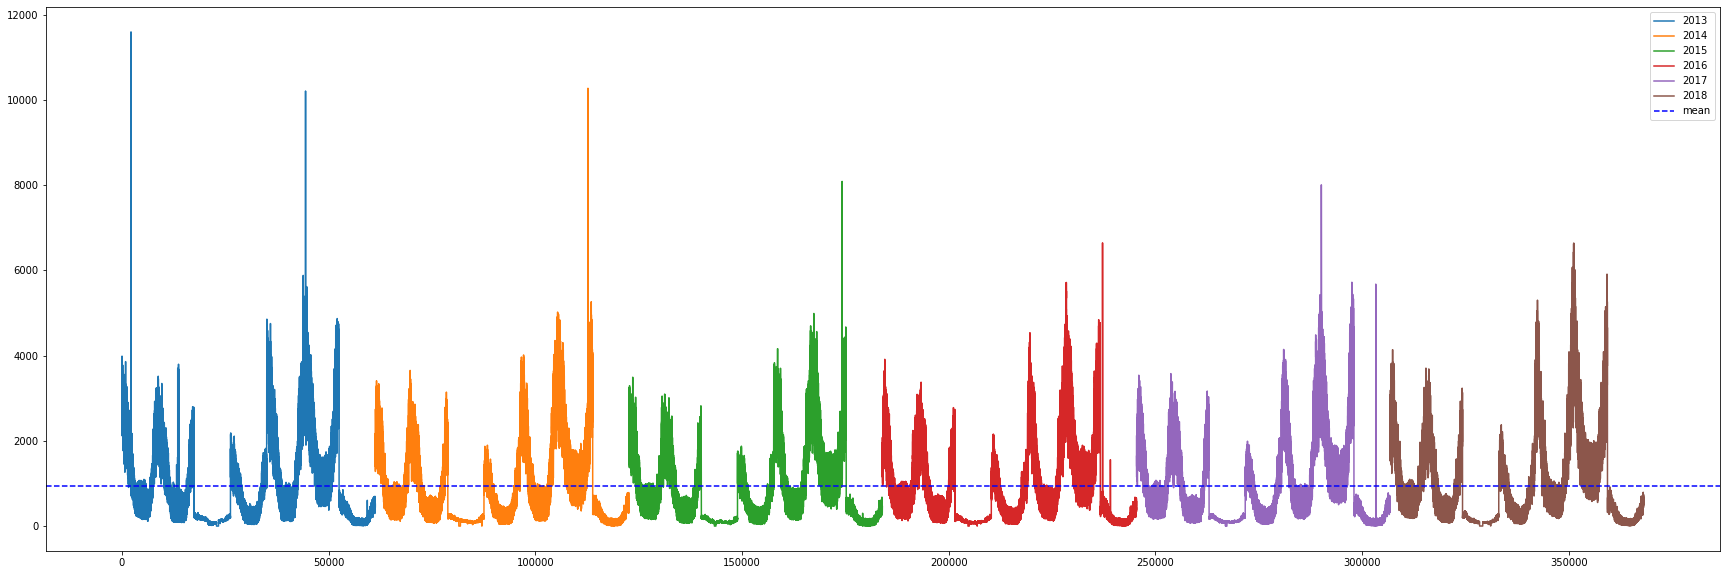

In [45]:
plt.figure(figsize=(30,10))
for i in total["year"].unique():
    df = total[total["year"]==i]
    plt.plot(df["공급량"], label=str(i))

plt.axhline(y=total["공급량"].mean(), linestyle='--', color='blue', label="mean")
plt.legend()
plt.show()

In [73]:
total['공급량'].mean()

948.1000366296196

### 구분별 공급량 추세
* 구분별 공급량은 큰 차이를 보임 -> 하지만 추세는 매우 비슷한 경향
* 간혹가다 훅 치솟는 부분은 어떤 날인지 확인 필요 
* 공급사가 전국적으로 퍼져있다면 지리적 요인도 변수가 될 수 있을 듯

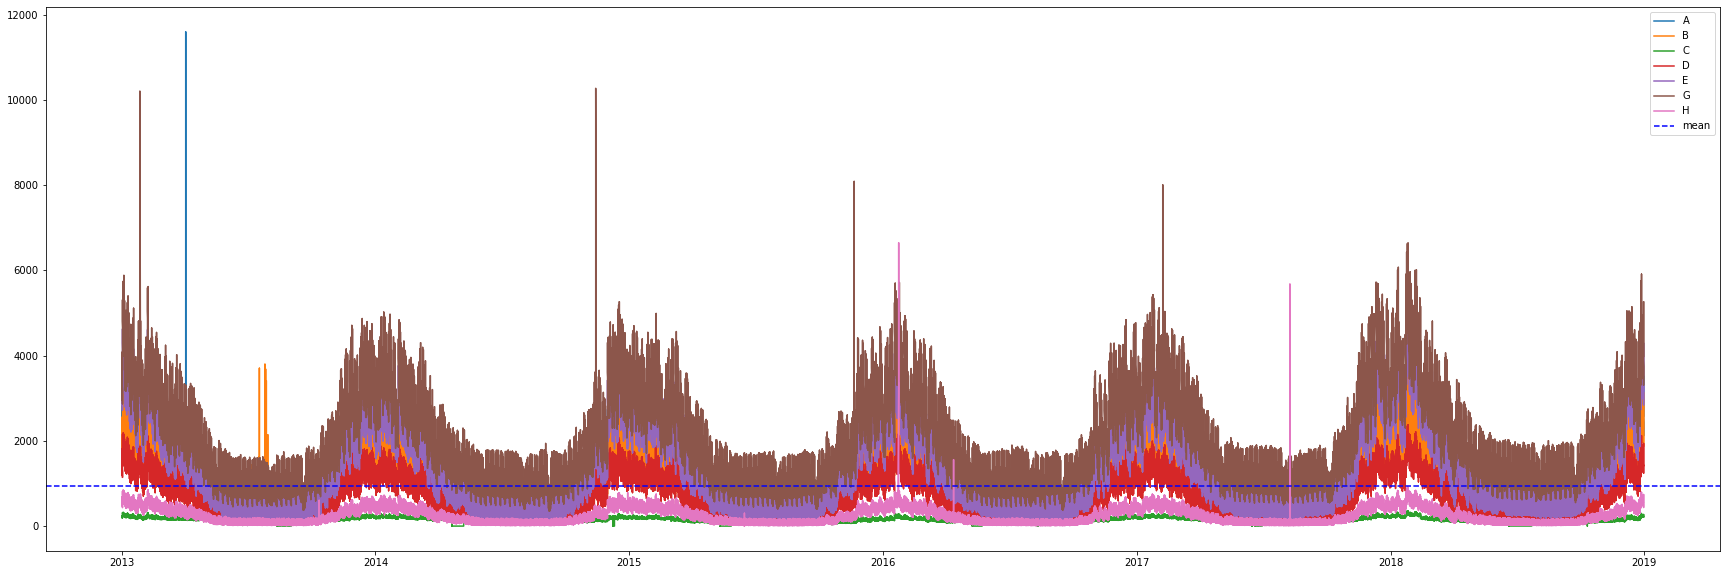

In [28]:
plt.figure(figsize=(30,10))
for i in total["구분"].unique():
    df = total[total["구분"]==i]
    plt.plot(df["연월일"], df["공급량"], label=str(i))

plt.axhline(y=total["공급량"].mean(), linestyle='--', color='blue', label="mean")
plt.legend()
plt.show()

### 계절별 공급량 추세
* season: 0(봄)~3(겨울)
* 연도별 계절별 평균 공급량 추세 확인
* 겨울의 압도적인 가스 공급량 확인 가능 -> 그에 비해 처참한 여름 공급량
* 의외로 __가을보다 봄의 가스 사용량이 많음__
* 또한 겨울 공급량은 15년도에 최저, 18년도에 최고였음 -> 기상데이터와 같이 확인 필요 

In [98]:
def season(x):
  if x in [3, 4, 5]:
    return 0        # 0: 봄
  elif x in [6, 7, 8]:
    return 1        # 1: 여름
  elif x in [9, 10, 11]:
    return 2        # 2: 가을
  else:
    return 3        # 3: 겨울  

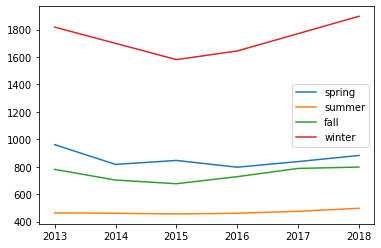

In [141]:
years = total['year'].unique()
df = pd.DataFrame(columns=['spring', 'summer', 'fall', 'winter'])

for year in years:
  연도별 = total[total['year']==year]
  계절별 = list(연도별.groupby('season')['공급량'].mean())
  df = df.append(pd.DataFrame([계절별], columns=['spring', 'summer', 'fall', 'winter']), ignore_index=True)

df = df.set_index(years)
df.plot()

### 시간별 공급량 추세
* 시간대별로도 꽤나 차이가 있으므로 얘도 변수화 할 수 있을 듯
* 근무일과 공휴일의 공급량이 차이난다는 거에서 착안 ->  근무 시간대(9to6)/그 외 시간대
* 아니면 단순하게 아침/점심/저녁/밤/새벽 등으로 쪼갤 수도 있고... 좀더 고민해보기

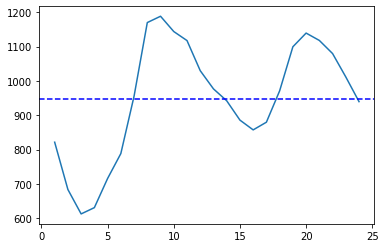

In [152]:
plt.plot(total["시간"].unique(), total.groupby("시간")["공급량"].mean())
plt.axhline(y=total["공급량"].mean(), linestyle='--', color='blue', label="mean")

### 요일별 공급량 추세
* weekday: 0(월요일)~6(일요일)
* workday: 1(평일)/0(주말) -> 나중에 __공휴일 정보 추가__ 예정
* __특수일 효과__: 일반적으로 공휴일에는 근무일에 비하여 도시가스 수요가 감소하는 패턴 
* 근무일 대비 특수일의 도시가스 감소 비율 추정 데이터: https://www.data.go.kr/data/15088557/fileData.do
* 확실히 평일의 가스공급량이 더 높음 -> 대신 추세는 거의 동일

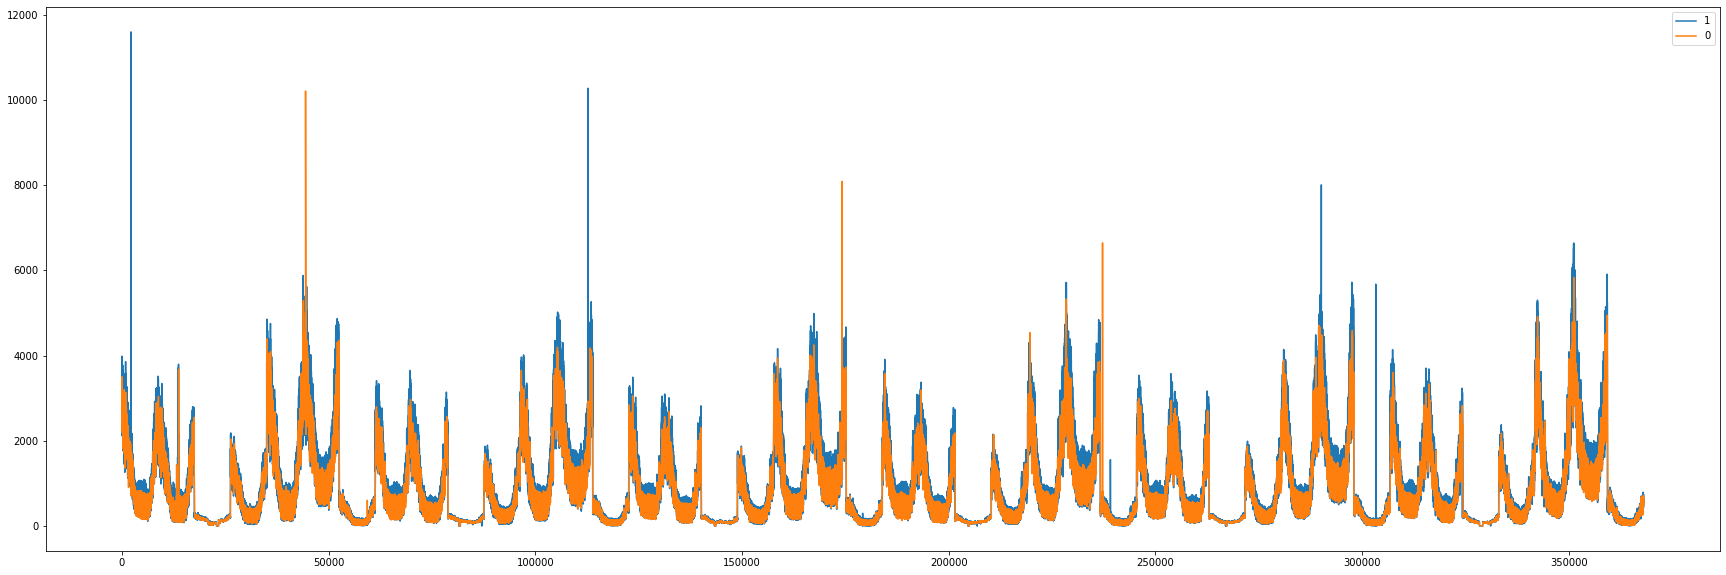

In [97]:
total['workday'] = total['weekday'].apply(lambda x: 1 if x in [0,1,2,3,4] else 0)

plt.figure(figsize=(30,10))
for i in total["workday"].unique():
    df = total[total["workday"]==i]
    plt.plot(df["공급량"], label=str(i))

plt.legend()
plt.show()

In [72]:
print(total[total['workday']==1]['공급량'].mean()) # 평일의 공급량
print(total[total['workday']==0]['공급량'].mean()) # 주말의 공급량

978.458828019841
872.2030581545702


### 이상치 탐색
* 전체 공급량에서 한 번씩 튀어오르는 부분 확인하고 달력에서 날짜 확인
* ...을 하려고 했으나 시간이 모질라서 잠시 미룸(^^)

### 상관관계 확인
* 큰 상관관계 순: season, month, 시간, workday, weekday, year, day
* 공급량과 특별히 강한 상관관계를 가지는 변수는 눈에 띄지 않음
* weekday와 workday는 안봐도 다중공선성 높을 거니까 둘 중 하나만 사용 -> workday
* 역시 month와 season도 다중공선성 높을 것으로 예상 -> month
* 베이스라인에서는 그냥 큰 거 두 개로 돌렸는데 **회귀분석 하거나 변수선택** 모델 써야될 듯
* 하지만... 거기까지는 귀찮아서 오늘은 그냥 뇌피셜로 돌림! 

In [153]:
total.columns

Index(['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', 'workday',
       'season'],
      dtype='object')

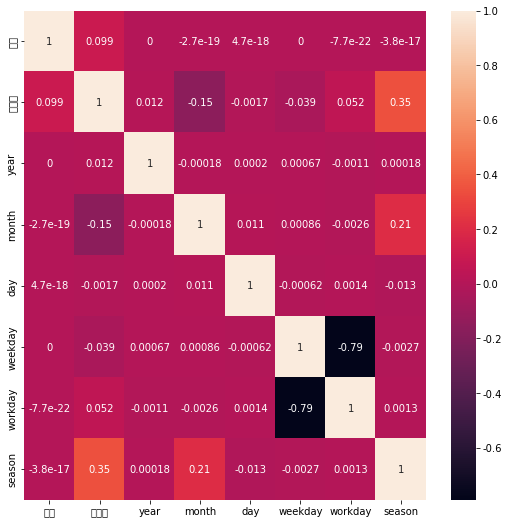

In [155]:
total.corr()

plt.figure(figsize=(9,9))
sns.heatmap(total.corr(), annot=True)

# PREPROCESS

### Encoding
* 구분 -> 레이블인코딩

In [156]:
d_map = {}

for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

### Feature Selection
* 변수 선택 과정은 외부데이터까지 고려해서 나중에 다시 생각

In [158]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [176]:
# features = ['month', '시간', '구분', 'workday', 'day'] -> 244.879/146.289/2.05
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

# Train
* 하이퍼파라미터 튜닝도...할 생각이었는데... 역시... 다음 기회에...

In [178]:
import lightgbm as lgb

d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 1000, d_val, verbose_eval=20, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds.
[20]	valid_0's l1: 244.879
[40]	valid_0's l1: 175.887
[60]	valid_0's l1: 159.177
[80]	valid_0's l1: 154.297
[100]	valid_0's l1: 152.184
[120]	valid_0's l1: 150.679
[140]	valid_0's l1: 149.346
[160]	valid_0's l1: 148.503
[180]	valid_0's l1: 147.982
[200]	valid_0's l1: 147.606
[220]	valid_0's l1: 147.283
[240]	valid_0's l1: 146.87
[260]	valid_0's l1: 146.601
[280]	valid_0's l1: 146.467
[300]	valid_0's l1: 146.408
[320]	valid_0's l1: 146.467
[340]	valid_0's l1: 146.349
[360]	valid_0's l1: 146.372
[380]	valid_0's l1: 146.45
Early stopping, best iteration is:
[349]	valid_0's l1: 146.289


# Predict

In [180]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [184]:
test['구분'] = test['구분'].map(d_map)
test['일자'] = pd.to_datetime(test['일자'])
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday
test['workday'] = test['weekday'].apply(lambda x: 1 if x in [0,1,2,3,4] else 0)

In [185]:
test_x = test[features]
preds = model.predict(test_x)

# Submit

In [186]:
sub['공급량'] = preds

In [187]:
sub.to_csv('jk_1029_lgbm.csv', index=False)